# Production éolienne

## Import des librairies

In [45]:
import pandas as pd
import numpy as np
import requests
from datetime import date, datetime, timezone

## Chargement des données - prod_eolienne.csv

- prod_eolienne.csv

In [46]:
df = pd.read_csv('/home/gaetansimplon/production_enr/data/prod_eolienne.csv')
display(df.dtypes)
display(df)


date              object
prod_eolienne    float64
dtype: object

,date,prod_eolienne
0,2016-09-01,100.000000
1,2016-09-02,100.000000
2,2016-09-03,100.000000
3,2016-09-04,96.844120
4,2016-09-05,97.088424
...,...,...
3303,2025-09-25,72.259819
3304,2025-09-26,52.211649
3305,2025-09-27,38.421115
3306,2025-09-28,55.810392


## En résumé du datasets
- 3308 entrées
- 2 colonnes 


In [47]:
display(df.dtypes)
display(df.describe())


date              object
prod_eolienne    float64
dtype: object

,prod_eolienne
count,3308.000000
mean,60.261740
std,27.466505
min,-48.997601
25%,44.321585
50%,61.730794
75%,76.859869
max,833.516984


### Valeurs manquantes et aberrantes

In [48]:
# Valeurs manquantes
df_missing = df.isnull().sum()
display(df_missing)

# Valeur extrême

df_weird = df.sort_values(by=['prod_eolienne'], ascending=True)
display(min(df_weird['prod_eolienne']))
display(df_weird)

df_max = df.sort_values(by=['prod_eolienne'], ascending=False)

print(df_max)

date             0
prod_eolienne    0
dtype: int64

-48.99760076569133

,date,prod_eolienne
2794,2024-05-04,-48.997601
2354,2023-02-19,7.077903
3262,2025-08-15,7.656243
2353,2023-02-18,8.626531
3261,2025-08-14,9.223880
...,...,...
1041,2019-07-17,100.000000
1043,2019-07-19,100.000000
1275,2020-03-07,100.000000
1014,2019-06-19,666.206615


            date  prod_eolienne
1002  2019-06-07     833.516984
1014  2019-06-19     666.206615
578   2018-04-07     100.000000
0     2016-09-01     100.000000
583   2018-04-12     100.000000
...          ...            ...
3261  2025-08-14       9.223880
2353  2023-02-18       8.626531
3262  2025-08-15       7.656243
2354  2023-02-19       7.077903
2794  2024-05-04     -48.997601

[3308 rows x 2 columns]


### Traitement des valeurs aberrantes
- Si valeur < 0 -> passage à une valeur absolue
- Si valeur > 100 -> passage à une valeur  NULL

In [49]:
# Fonction pour traiter les valeurs aberrantes

def clean_value(number):
    if number < 0:
        number = abs(number)
    if number > 100:
        return None
    return number

# Nettoyage des valeurs aberrantes
df['prod_eolienne'] = df['prod_eolienne'].apply(clean_value)
# Retrait des valeurs entrées à valeurs manquantes
df = df.dropna()

display(df.isnull().sum())
display(df.describe())
display(df.sort_values(by=['prod_eolienne']))

date             0
prod_eolienne    0
dtype: int64

,prod_eolienne
count,3306.000000
mean,59.874200
std,21.427358
min,7.077903
25%,44.331044
50%,61.704084
75%,76.830423
max,100.000000


,date,prod_eolienne
2354,2023-02-19,7.077903
3262,2025-08-15,7.656243
2353,2023-02-18,8.626531
3261,2025-08-14,9.223880
3036,2025-01-01,9.357384
...,...,...
1987,2022-02-17,100.000000
1607,2021-02-02,100.000000
1905,2021-11-27,100.000000
1,2016-09-02,100.000000


### Conversion de la colonne 'date' au format datetime

In [50]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

display(df.dtypes)

/tmp/ipykernel_8397/1996876030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')


date             datetime64[ns]
prod_eolienne           float64
dtype: object

# Dataset météo - param_eolienne.csv
- Vitesse moyenne du vent (10m)
- Direction du vent
- Température
- Pression atmosphérique (niveau de la mer)

Données récoltées depuis l'API open-meteo

In [51]:
# Chargement
df_param = pd.read_csv('/home/gaetansimplon/production_enr/data/param_eolienne.csv')


# Mise au format datetime
df_param['time'] = pd.to_datetime(df_param['time'])
# Renommage colonne date (time -> date)
df_param.rename(columns={'time': 'date'}, inplace=True)

print(df_param)

           date  winddirection_10m_dominant (°)  wind_speed_10m_mean (km/h)  \
0    2016-09-01                             269                        12.0   
1    2016-09-02                             234                        12.6   
2    2016-09-03                             237                        11.5   
3    2016-09-04                             270                        11.6   
4    2016-09-05                             307                        17.6   
...         ...                             ...                         ...   
3312 2025-09-26                             306                         6.4   
3313 2025-09-27                             355                         6.3   
3314 2025-09-28                               2                         5.4   
3315 2025-09-29                             340                         4.4   
3316 2025-09-30                             357                         7.3   

      temperature_2m_mean (°C)  pressure_msl_mean (

In [52]:
# Résumé
display('Résumé : ',df_param.describe())

# Types de données

display('Types des données : ',df_param.dtypes)

## Missing values

display('Valeurs manquantes : ', df_param.isnull().sum())

## Doublons

display('Doublons :', df_param.duplicated().sum())

'Résumé : '

,date,winddirection_10m_dominant (°),wind_speed_10m_mean (km/h),temperature_2m_mean (°C),pressure_msl_mean (hPa)
count,3317,3317.000000,3317.000000,3317.000000,3317.000000
mean,2021-03-17 00:00:00,214.220380,12.146367,15.574977,1016.976485
min,2016-09-01 00:00:00,0.000000,3.500000,-2.200000,987.900000
25%,2018-12-09 00:00:00,113.000000,8.600000,10.000000,1013.300000
50%,2021-03-17 00:00:00,268.000000,10.900000,15.000000,1016.700000
75%,2023-06-24 00:00:00,316.000000,14.700000,21.400000,1020.800000
max,2025-09-30 00:00:00,360.000000,43.100000,33.600000,1038.400000
std,NaN,119.203858,4.924862,6.928749,6.927902


'Types des données : '

date                              datetime64[ns]
winddirection_10m_dominant (°)             int64
wind_speed_10m_mean (km/h)               float64
temperature_2m_mean (°C)                 float64
pressure_msl_mean (hPa)                  float64
dtype: object

'Valeurs manquantes : '

date                              0
winddirection_10m_dominant (°)    0
wind_speed_10m_mean (km/h)        0
temperature_2m_mean (°C)          0
pressure_msl_mean (hPa)           0
dtype: int64

'Doublons :'

np.int64(0)

# Feature Engineering


**Encodage des données de direction du vent**

- Afin de signifier l'aspect 'circulaire' de ce type de données, il est nécessaire d'encoder ces dernières.
- Transformer une valeur d'angle en deux valeurs : sin (nord-sud) et cos (est-ouest)
- Ces deux nouvelles valeurs seront des features indépendantes pour l'entrainement du modèle

**Saisonalité**

- Prise en compte des mois de l'année

**Traitement de la vitesse du vent** 

- La puissance du vent dépend du cube de la vitesse du vent, il faut donc en rendre compte dans nos données

**Interactions entre les données**

- Vitesse du vent x Direction du vent (wind_speed*wind_dir_sin | wind_dir_cos)
- Température x Pression

**Standardisation des données**

- Certains modèles nécessitent d'avoir des données normalisées/standardisées (Ridge, Lasso...)

In [53]:
# Mise en fonction de la conversion de la direction du vent

def convert_wind_dir(df: pd.DataFrame, col_name: str='winddirection_10m_dominant (°)') -> pd.DataFrame:
    """
    Encode une colonne d'angle en degrés (0-360) sous forme trigonométrique (sin, cos).
    
    Args:
        df (pd.DataFrame): DataFrame contenant la colonne d'angle en degrés.
        col_name (str): Nom de la colonne contenant la direction du vent en degrés.
    
    Returns:
        pd.DataFrame: DataFrame avec deux nouvelles colonnes ('wind_dir_sin', 'wind_dir_cos'),
                      et sans la colonne d'origine en degrés ni sa version en radians.
    """
    df = df.copy()
    # renommage
    df = df.rename(columns={col_name: 'wind_direction'})
    # conversion en radians
    df['wind_direction_rad'] = np.deg2rad(df['wind_direction'])
    # encodage trigo
    df['wind_dir_sin'] = np.sin(df['wind_direction_rad'])
    df['wind_dir_cos'] = np.cos(df['wind_direction_rad'])
    # suppression colonnes précédentes
    df = df.drop(columns=['wind_direction', 'wind_direction_rad'])
    return df
    

    

### Encodage de variables temporelle

- Création d'une variable 'mois' pour enrichir le nombre de variable d'entrainement

In [54]:

def convert_date_to_month(df: pd.DataFrame, col_name: str='date') -> pd.DataFrame:
    """
    Convertit la colonne 'date' au format datetime
    """
    df = df.copy()
    # Conversion en datetime
    df[col_name] = pd.to_datetime(df[col_name])
    # Création de la variable month
    df['month'] = df[col_name].dt.month
    return df

## Traitement de la variable de vitesse du vent


- **Potentiel énergétique du vent** : Rend compte de la relation concrète et physique exacte entre le vent et la puissance soit vitesse moyenne du vent au cube (wind_speed3)

- **Température et pression**: Rend compte de l'interaction entre la température et la pression pour donner une valeur approximative de la densité de l'air. La densité de l'air influence la puissance du vent (temp_press)

In [55]:
def compute_wind_param(df: pd.DataFrame) -> pd.DataFrame:
    """Ajoute les features dérivées pour la production éolienne :
    - wind_speed^3
    - composantes cos et sin de la vitesse du vent selon la direction
    - interaction température * pression

    """
    df = df.copy()
    
    # Puissance du vent
    df['wind_speed3'] = df['wind_speed_10m_mean (km/h)']**3
    
    # Composantes selon direction
    
    df['wind_cos'] = df['wind_speed_10m_mean (km/h)'] * df['wind_dir_cos']
    df['wind_sin'] = df['wind_speed_10m_mean (km/h)'] * df['wind_dir_sin']
    
    # Interaction température * pression
    
    df['temp_press'] = (df['temperature_2m_mean (°C)'] * df['pressure_msl_mean (hPa)'])
    
    return df
    
    

## Standardisation des données pour l'entrainement

Si nécessaire

In [56]:
from sklearn.preprocessing import StandardScaler

def standardize_features(df: pd.DataFrame, cols_to_scale: list[str]) -> pd.DataFrame:
    """
    Standardise les colonnes sélectionnées
    """
    
    df = df.copy()
    
    scaler = StandardScaler()
    
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    
    return df    

## Pipeline de prétraitement des données

- Fusion du dataset de production et de paramètres météo

In [57]:
## Fusion des dataframes

df_merged = pd.merge(
    df, df_param,
    on='date', how='inner'
)

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Pipeline de prétraitement des données météo
    """
    # Conversion date -> datetime
    df = convert_date_to_month(df)
    # Conversion variable direction du vent (degré -> sin/cos)
    df = convert_wind_dir(df)
    # Mise en relation des données sur la puissance/vitesse du vent et pression * température
    df = compute_wind_param(df)
    
    return df

df_merged = preprocess_data(df_merged)

# Entrainement

## Random Forest Regressor

### Imports

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import  r2_score, mean_absolute_error, mean_squared_error


### Définition des features et target

In [ ]:
# Définition des features

features = ['wind_speed_10m_mean (km/h)', 'wind_speed3', 'temp_press']

X = df_merged[features]

y = df_merged['prod_eolienne']

### Split temporel (80% train / 20% test)

Les données représentent une évolution dans le temps, un train_test_split aléatoire mélangerait passé et futur, ce qui provoquerait une fuite de données (data leakage)

**Data leakage** 

-> "Si tu entraînes un modèle avec des données de 2024 pour prédire 2023, il 'triche' en utilisant des données futures."

In [60]:
split_ratio = 0.8 
split_index = int(len(X) * split_ratio)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

### Définition du Random Forest

In [61]:
rf = RandomForestRegressor(random_state=5, n_jobs=-1)

### Validation croisée temporelle simple

In [62]:
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(rf, X_train, y_train, cv=tscv, scoring='r2', n_jobs=-1)
print('R² Cross-Validation avant tuning :', scores.mean(), "+/-", scores.std())

R² Cross-Validation avant tuning : 0.440956986852769 +/- 0.05221510502181809


### Optimisation des hyperparamètres

In [63]:


param_grid = {
    'n_estimators': [200, 400, 800],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

search = RandomizedSearchCV(
    rf, param_distributions=param_grid, n_iter=20,
    cv=5, scoring='r2', random_state=5, n_jobs=-1
)

search.fit(X_train, y_train)
print("Meilleurs paramètres :", search.best_params_)
print("Meilleur score CV :", search.best_score_)


Meilleurs paramètres : {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5}
Meilleur score CV : 0.5027013659148568


### Application des hyperparamètres optimaux

In [64]:
# Selection du modèle avec les hyperparamètres opti
best_rf = search.best_estimator_
# Prédiction sur les données train et test
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)
# Résultats
print("R2 train :", r2_score(y_train, y_train_pred))
print("R2 test  :", r2_score(y_test, y_test_pred))
print("MAE :", mean_absolute_error(y_test, y_test_pred))
print("MSE :", mean_squared_error(y_test, y_test_pred))

R2 train : 0.5765693158193423
R2 test  : 0.46277640619772165
MAE : 12.72609120786513
MSE : 246.69089402605488


### Visualisation : réel vs prédit

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

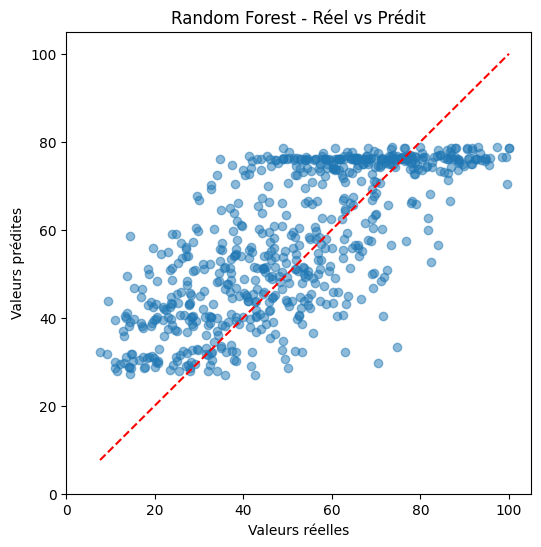

In [66]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlim(0, max(y_test.max(), y_test_pred.max())*1.05)
plt.ylim(0, max(y_test.max(), y_test_pred.max())*1.05)
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title("Random Forest - Réel vs Prédit")
plt.show()

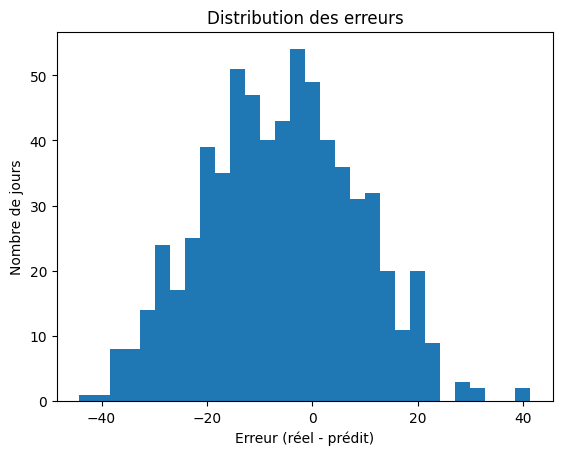

In [67]:
errors = y_test - y_test_pred
plt.hist(errors, bins=30)
plt.xlabel("Erreur (réel - prédit)")
plt.ylabel("Nombre de jours")
plt.title("Distribution des erreurs")
plt.show()

### Importance des features

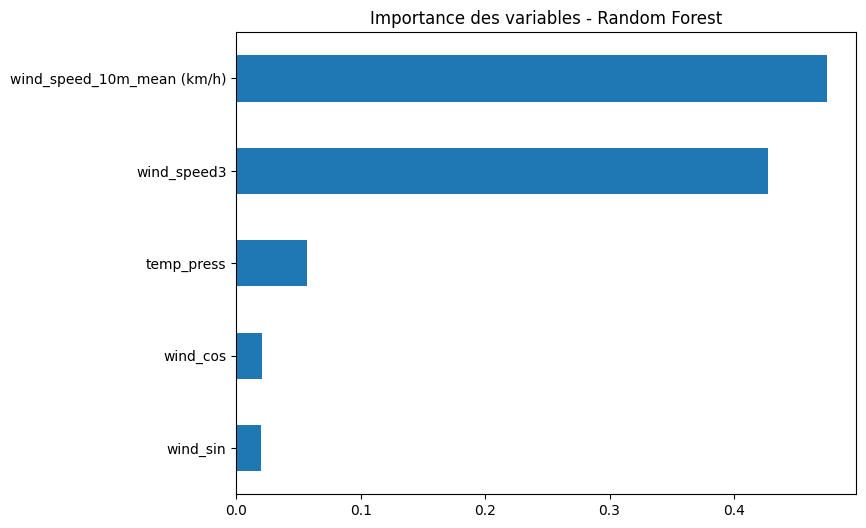

In [68]:
importances = pd.Series(best_rf.feature_importances_, index=features).sort_values()
importances.plot(kind='barh', figsize=(8,6))
plt.title("Importance des variables - Random Forest")
plt.show()

## XGBoost


### Imports

In [69]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

### Entrainement

In [70]:
xgb_model = XGBRegressor()
# Adaptation du modèle aux données
xgb_model.fit(X_train, y_train)
# Prédictions
y_pred = xgb_model.predict(X_test)
# Evaluation
print("R² : ", r2_score(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test, y_pred))
print("MSE :", mean_squared_error(y_test, y_pred))


R² :  0.3889527427096502
MAE : 13.375662889077613
MSE : 280.5904206966084


### Recherche d'hyperparamètres optimaux

In [71]:
# Split temporel (5 périodes)
tscv = TimeSeriesSplit(n_splits=5)

# Paramètrage de la grid

param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

# Entrainement
grid_search.fit(X_train, y_train)

# Résultats
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score (R²) :", grid_search.best_score_)





Fitting 5 folds for each of 72 candidates, totalling 360 fits
Meilleurs hyperparamètres : {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.7}
Meilleur score (R²) : 0.48842368299602523


In [72]:
# Utilisation des paramètres optimaux

best_xgb = grid_search.best_estimator_

# Prédictions
y_pred_train = best_xgb.predict(X_train)
y_pred_test = best_xgb.predict(X_test)

# Évaluation
print("R2 train :", r2_score(y_train, y_pred_train))
print("R2 test  :", r2_score(y_test, y_pred_test))
print("MAE :", mean_absolute_error(y_test, y_pred_test))
print("MSE :", mean_squared_error(y_test, y_pred_test))

R2 train : 0.5588072172483631
R2 test  : 0.4513763165839527
MAE : 12.971148288688221
MSE : 251.92576891100427


## Comparaison des modèles

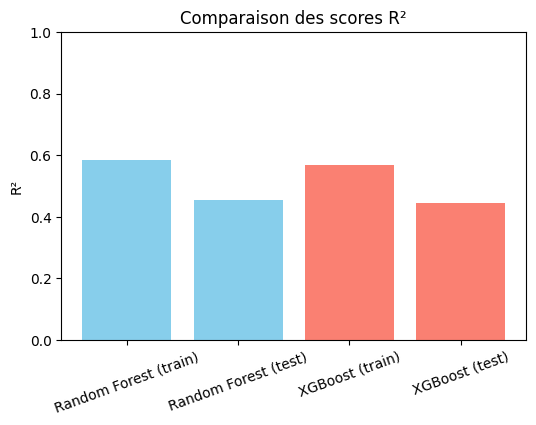

In [73]:
plt.figure(figsize=(6,4))
plt.bar(['Random Forest (train)', 'Random Forest (test)', 
         'XGBoost (train)', 'XGBoost (test)'],
        [0.584, 0.456, 0.568, 0.444],
        color=['skyblue','skyblue','salmon','salmon'])
plt.title('Comparaison des scores R²')
plt.xticks(rotation=20)
plt.ylabel('R²')
plt.ylim(0,1)
plt.show()


### Interpréation

Les deux modèles (Random Forest et XGBoost) donnent des performances proches.

Random Forest obtient légèrement de meilleurs scores sur toutes les métriques (R², MAE, MSE).

XGBoost généralise presque aussi bien, mais avec une régularisation un peu plus forte, ce qui explique ses scores légèrement inférieurs.

**En résumé** : les deux modèles sont cohérents et fiables, mais Random Forest reste le plus performant sur ce jeu de données.